<a href="https://colab.research.google.com/github/rll/deepul/blob/master/homeworks/hw2/hw2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started

## Overview
This semester, all homeworks will be conducted through Google Colab notebooks. All code for the homework assignment will be written and run in this notebook. Running in Colab will automatically provide a GPU, but you may also run this notebook locally by following [these instructions](https://research.google.com/colaboratory/local-runtimes.html) if you wish to use your own GPU.

You will save images in the notebooks to use and fill out a given LaTeX template which will be submitted to Gradescope, along with your notebook code.

## Using Colab
On the left-hand side, you can click the different icons to see a Table of Contents of the assignment, as well as local files accessible through the notebook.

Make sure to go to **Runtime -> Change runtime type** and select **GPU** as the hardware accelerator. This allows you to use a GPU. Run the cells below to get started on the assignment. Note that a session is open for a maximum of 12 hours, and using too much GPU compute may result in restricted access for a short period of time. Please start the homework early so you have ample time to work.

**If you loaded this notebook from clicking "Open in Colab" from github, you will need to save it to your own Google Drive to keep your work.**

## General Tips
In each homework problem, you will implement various autoencoder models and run them on two datasets (dataset 1 and dataset 2). The expected outputs for dataset 1 are already provided to help as a sanity check.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

After you complete the assignment, download all of the image outputted in the results/ folder and upload them to the figure folder in the given latex template.

Run the cells below to download and load up the starter code. It may take longer to run since we are using larger datasets.

In [ ]:
# from PyQt5.QtGui.QRawFont import weight
# !if [ -d deepul ]; then rm -Rf deepul; fi
!git clone https://github.com/rll/deepul.git
!curl "https://drive.usercontent.google.com/download?id=1lWjGICwgzgcBDejo9S5g69hLAf0O3lGF&confirm=xxx" -o hw2_data.zip
# !unzip -qq hw2_data.zip -d deepul/homeworks/hw2/data
!pip install ./deepul


[hw2_data.zip]
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of hw2_data.zip or
        hw2_data.zip.zip, and cannot find hw2_data.zip.ZIP, period.


In [5]:
from deepul.hw2_helper import *
import numpy as np
import torch
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.nn
import torch.nn.utils as utils
from torch import nn
from tqdm import tqdm

# Question 1: VAEs on 2D Data [20pts]
In this question, you will train a simple VAE on 2D data, and look at situations in which latents are being used or not being used (i.e. when posterior collapse occurs)

## Part (a) Data from a Full Covariance Gaussian [10 pts]
In this part, we train a VAE on data generated from a Gaussian with a full covariance matrix. Execute the cell below to visualize the datasets.

Dataset 1


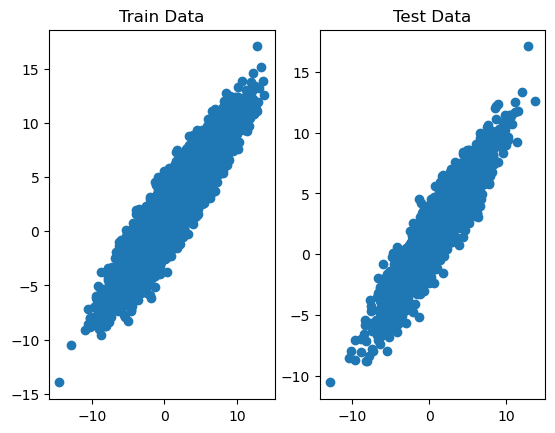

Dataset 2


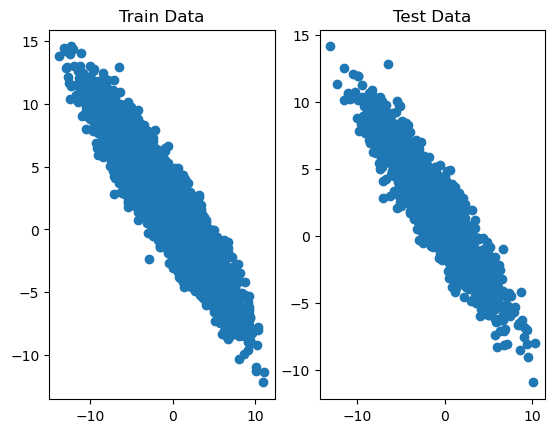

In [2]:
visualize_q1_data('a', 1)
visualize_q1_data('a', 2)

Consruct and train a VAE with the following characteristics
*   2D latent variables $z$ with a standard normal prior, $p(z) = N(0, I)$
*   An approximate posterior $q_\theta(z|x) = N(z; \mu_\theta(x), \Sigma_\theta(x))$, where $\mu_\theta(x)$ is the mean vector, and $\Sigma_\theta(x)$ is a diagonal covariance matrix
*   A decoder $p(x|z) = N(x; \mu_\phi(z), \Sigma_\phi(z))$, where $\mu_\phi(z)$ is the mean vector, and $\Sigma_\phi(z)$ is a diagonal covariance matrix

**You will provide the following deliverables**


1.   Over the course of training, record the average full negative ELBO, reconstruction loss $E_xE_{z\sim q(z|x)}[-p(x|z)]$, and KL term $E_x[D_{KL}(q(z|x)||p(z))]$ of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
2.   Report the final test set performance of your final model
3. Samples of your trained VAE with ($z\sim p(z), x\sim N(x;\mu_\phi(z),\Sigma_\phi(z))$) and without ($z\sim p(z), x = \mu_\phi(z)$) decoder noise




### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [42]:
def q1(train_data, test_data, part, dset_id):
    """
    train_data: An (n_train, 2) numpy array of floats
    test_data: An (n_test, 2) numpy array of floats

    (You probably won't need to use the two inputs below, but they are there
     if you want to use them)
    part: An identifying string ('a' or 'b') of which part is being run. Most likely
          used to set different hyperparameters for different datasets
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
    - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
    - a numpy array of size (1000, 2) of 1000 samples WITH decoder noise, i.e. sample z ~ p(z), x ~ p(x|z)
    - a numpy array of size (1000, 2) of 1000 samples WITHOUT decoder noise, i.e. sample z ~ p(z), x = mu(z)
    """

    class ToyDataset(Dataset):
        def __init__(self, data: np.array):
            self.data = data

        def __len__(self):
            return self.data.shape[0]

        def __getitem__(self, idx):
            return self.data[idx]


    class VAE(nn.Module):
        def __init__(self, input_size: int, hidden_size: int, latent_size: int):
            super(VAE, self).__init__()

            self.input_size = input_size
            self.latent_size = latent_size

            self.encoder = nn.Sequential(nn.Linear(input_size, hidden_size), nn.ReLU(), nn.Linear(hidden_size, 2 * latent_size))
            self.decoder = nn.Sequential(nn.Linear(latent_size, hidden_size), nn.ReLU(), nn.Linear(hidden_size, 2 * input_size))

        def encode(self, x):
            z = self.encoder(x)
            mu  = z[:, :self.latent_size]
            logsvar = z[:, self.latent_size:]
            std = torch.exp(0.5 * logsvar)
            eps = torch.randn_like(std)

            z = eps * std + mu
            return z, mu, logsvar

        def decode(self, z):
            h = self.decoder(z)
            mu = h[:, :self.input_size]
            logsvar = h[:, self.input_size:]
            std = torch.exp(0.5 * logsvar)
            eps = torch.randn_like(std)

            return eps * std + mu

        def forward(self, x: torch.Tensor) -> torch.Tensor:
            z, mu, logsvar = self.encode(x)

            out = self.decode(z)

            return out, mu, logsvar


        def sample(self, num: int, with_noise: bool) -> torch.Tensor:
            z = torch.randn((num, self.latent_size))
            if with_noise:
                return self.decode(z).detach().numpy()
            else:
                h = self.decoder(z).detach().numpy()
                return h[:, :self.input_size]


    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    device = "cpu"
    print(device)

    train_dataset = ToyDataset( train_data)
    train_dataloader = DataLoader(train_dataset, batch_size=512, shuffle=True)

    test_dataset = ToyDataset(test_data)
    test_dataloader = DataLoader(test_dataset, batch_size=512, shuffle=False)

    model = VAE(2, 512, 2).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=1e-3)

    train_losses = []
    test_losses = []
    for e in tqdm(range(10)):
        model.train()
        for X in train_dataloader:
            logits, mu, logsvar = model(X.to(device))

            optimizer.zero_grad()

            mse = F.mse_loss(logits, X, reduction='mean')
            kl_loss = -0.5 * torch.mean(1 + logsvar - mu ** 2 - torch.exp(logsvar))
            loss = mse + kl_loss

            loss.backward()
            optimizer.step()

            train_losses.append(np.array([loss.item(), mse.item(), kl_loss.item()]))


        ll = 0
        mse = 0
        kl_loss = 0
        model.eval()
        with torch.no_grad():
            for Y in test_dataloader:

                logits, mu, logsvar = model(Y.to(device))
                mse += F.mse_loss(logits, Y, reduction='sum')
                kl_loss += -0.5 * torch.sum(1 + logsvar - mu ** 2 - torch.exp(logsvar))
                ll += mse + kl_loss

            test_losses.append(np.array([ll, mse, kl_loss]) / len(test_dataloader))


    model.eval()
    samples_with_noise = model.sample(1000, with_noise=True)
    samples = model.sample(1000, with_noise=False)

    return np.stack(train_losses), np.stack(test_losses), samples_with_noise, samples

### Results
Once you've finished `q1_a`, execute the cells below to visualize and save your results.

cpu


100%|██████████| 10/10 [00:00<00:00, 18.43it/s]


Final -ELBO: 5044.9370, Recon Loss: 535.9767, KL Loss: 1127.8772


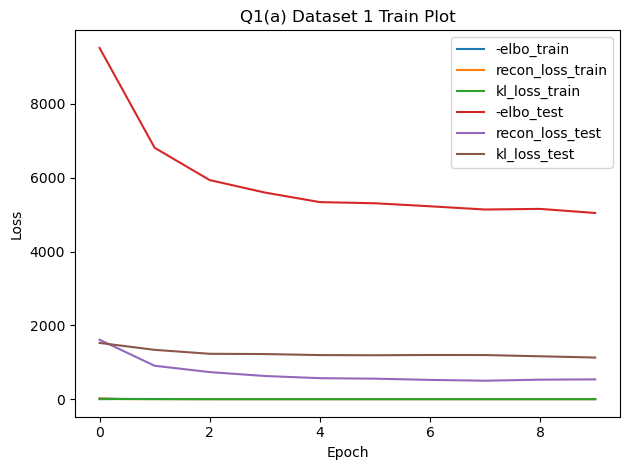

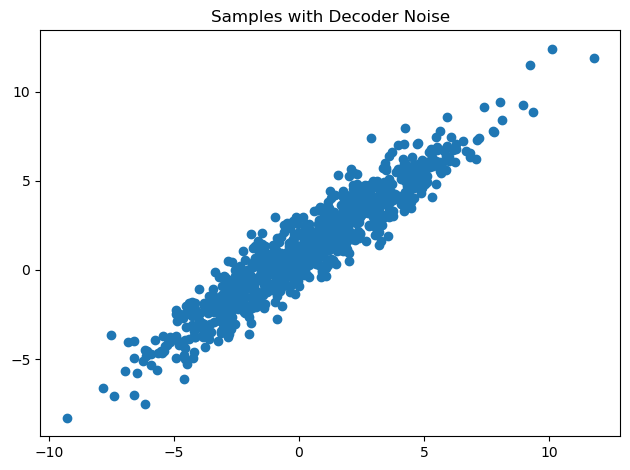

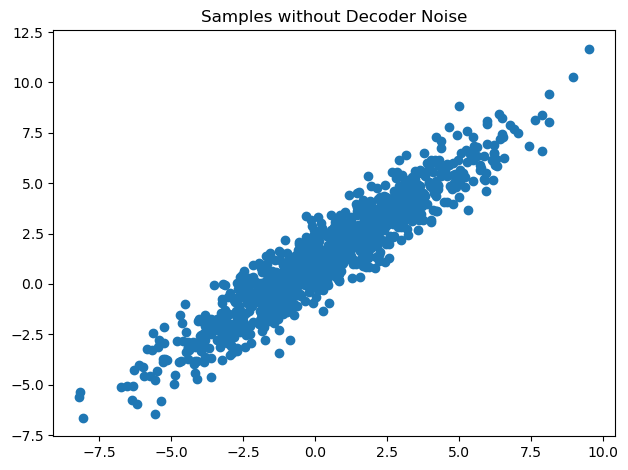

In [43]:
q1_save_results('a', 1, q1)

cpu


100%|██████████| 10/10 [00:00<00:00, 17.98it/s]


Final -ELBO: 5111.0898, Recon Loss: 575.0735, KL Loss: 1106.8157


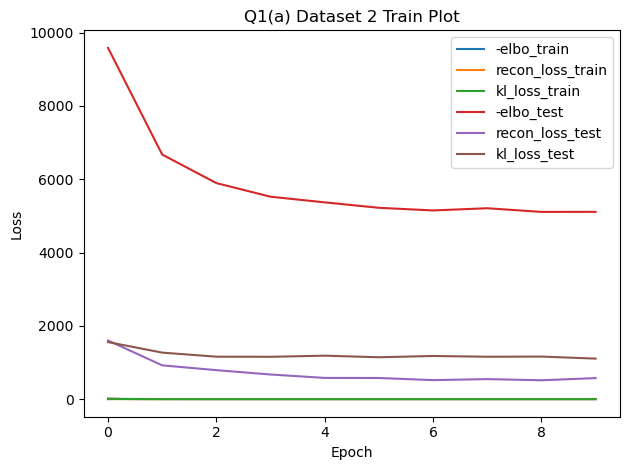

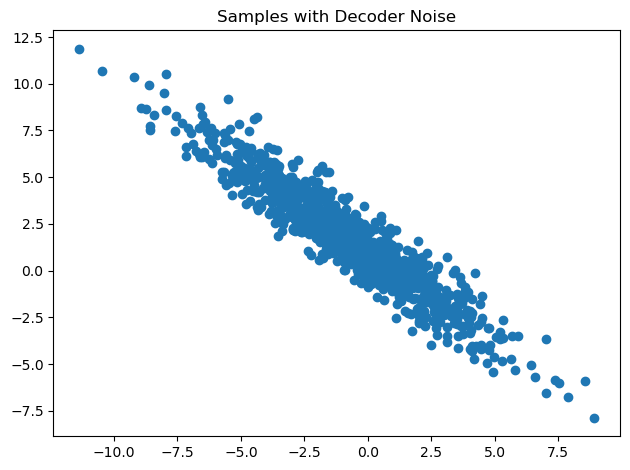

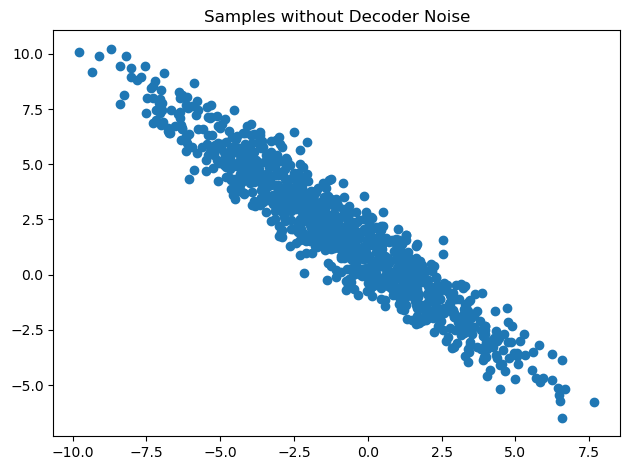

In [44]:
q1_save_results('a', 2, q1)

## Part (b) Data from a Diagonal Gaussian [10pts]
In this part, we use your code from the previous part to train a VAE on data generated from a diagonal gaussian. Execute the cell below to visualize the datasets (note that they may look the same, but notice the axes)

Dataset 1


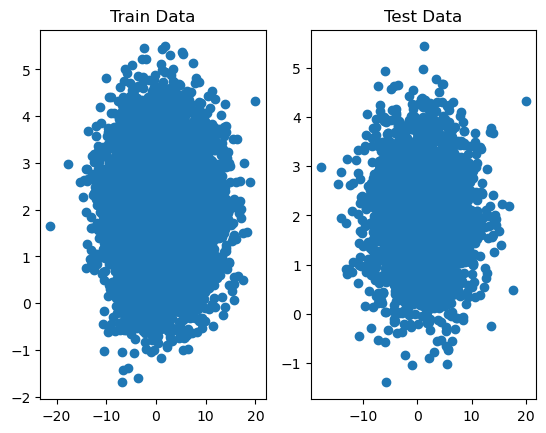

Dataset 2


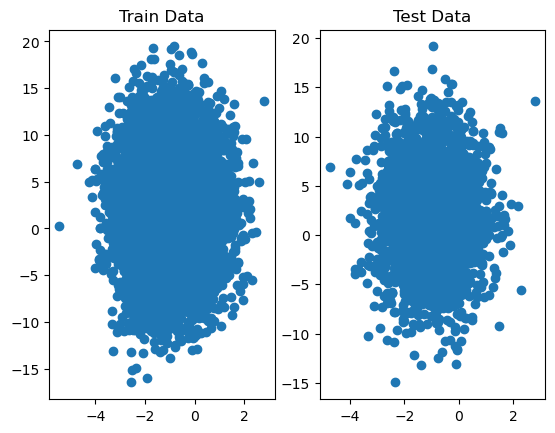

In [81]:
visualize_q1_data('b', 1)
visualize_q1_data('b', 2)

### Results
Execute the cells below to visualize and save your results.

cpu


100%|██████████| 10/10 [00:00<00:00, 18.55it/s]


Final -ELBO: 5122.1104, Recon Loss: 553.1105, KL Loss: 1133.3710


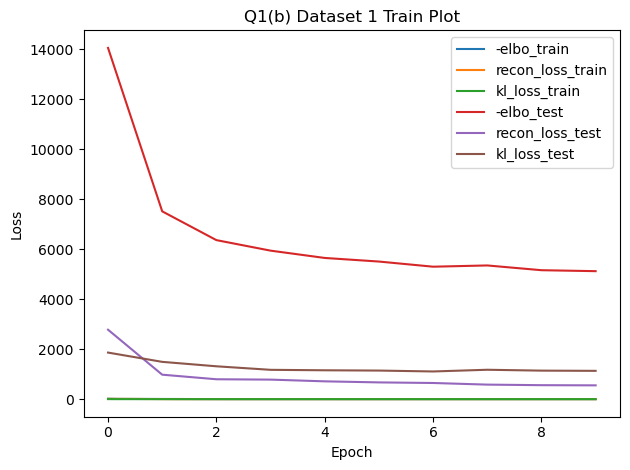

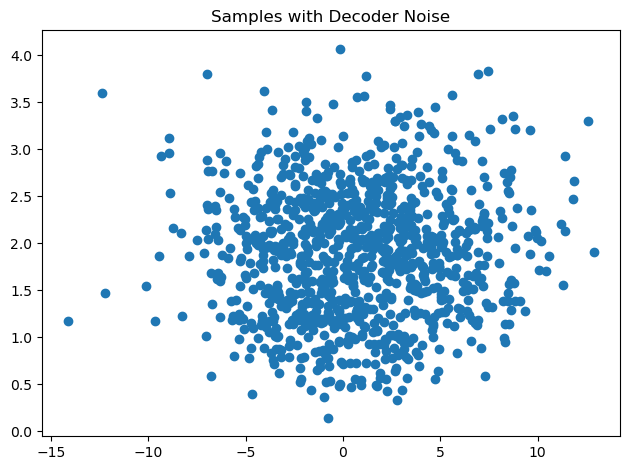

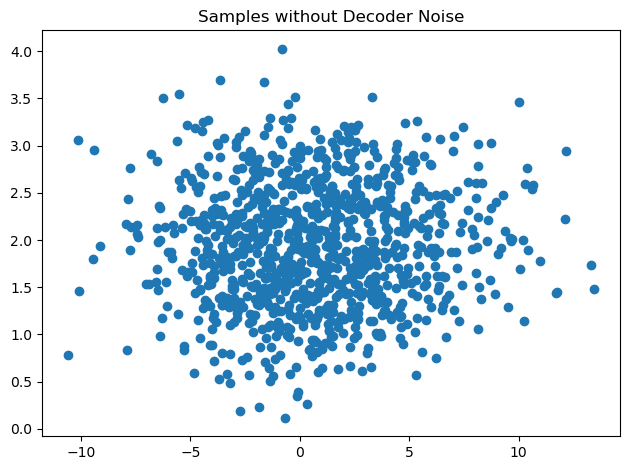

In [82]:
q1_save_results('b', 1, q1)

cpu


100%|██████████| 10/10 [00:00<00:00, 18.52it/s]


Final -ELBO: 5251.6543, Recon Loss: 605.3534, KL Loss: 1118.7720


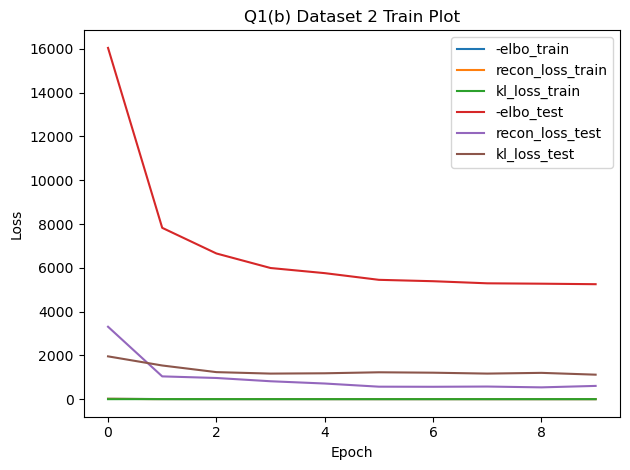

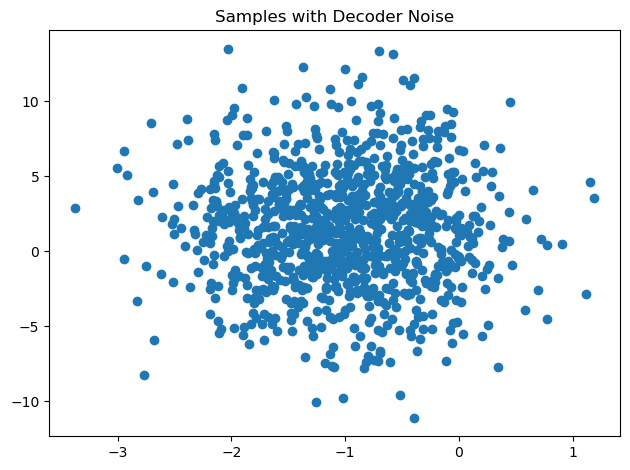

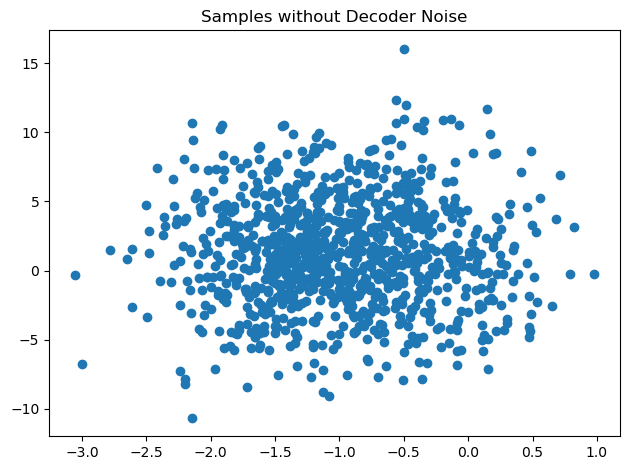

In [83]:
q1_save_results('b', 2, q1)

### Reflection
Compare the sampled xs with and without latents in parts (a) and (b). For which datasets are the latents being used? Why is this happening (i.e. why are the latents being ignored in some cases)? **Write your answer (1-2 sentences) in the given latex template**

# Question 2: VAEs on Images [40pts]
In this question, you will train different VAE models on image datasets. Execute the cell below to visualize the two datasets (colored shapes, and [SVHN](http://ufldl.stanford.edu/housenumbers/)).

In [25]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

dataset = {}
dataset['train'] = np.array(unpickle("data/cifar-10-batches-py/data_batch_1")[b'data'])
dataset['train'] = np.concatenate([dataset['train'], np.array(unpickle("data/cifar-10-batches-py/data_batch_2")[b'data'])], axis=0)
dataset['train'] = np.concatenate([dataset['train'], np.array(unpickle("data/cifar-10-batches-py/data_batch_3")[b'data'])], axis=0)
dataset['train'] = np.concatenate([dataset['train'], np.array(unpickle("data/cifar-10-batches-py/data_batch_4")[b'data'])], axis=0)
dataset['train'] = np.concatenate([dataset['train'], np.array(unpickle("data/cifar-10-batches-py/data_batch_5")[b'data'])], axis=0)
dataset['train'] = dataset['train'].reshape((-1, 3, 32, 32)).transpose((0, 2, 3, 1))
dataset['test'] = np.array(unpickle("data/cifar-10-batches-py/test_batch")[b'data'])
dataset['test'] = dataset['test'].reshape((-1, 3, 32, 32)).transpose((0, 2, 3, 1))
print(dataset['train'].shape, dataset['test'].shape)

with open("data/cifar10.pkl", "wb") as f:
    pickle.dump(dataset, f)

(50000, 32, 32, 3) (10000, 32, 32, 3)


In [40]:
import scipy.io

dataset = {}
train = scipy.io.loadmat("data/train_32x32.mat")
dataset['train'] = train['X'].transpose((3, 0, 1, 2))

test = scipy.io.loadmat("data/test_32x32.mat")
dataset['test'] = test['X'].transpose((3, 0, 1, 2))

print(dataset['train'].shape, dataset['test'].shape)

with open("data/svhn.pkl", "wb") as f:
    pickle.dump(dataset, f)

(73257, 32, 32, 3) (26032, 32, 32, 3)


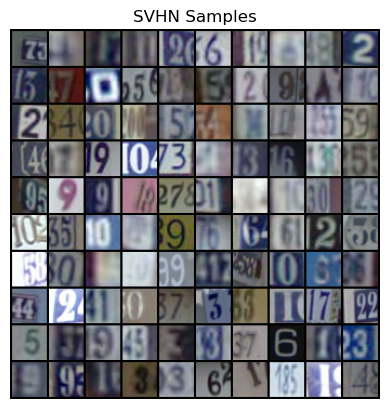

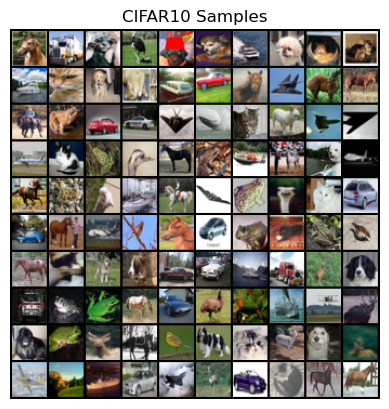

In [7]:
visualize_svhn()
visualize_cifar10()

## Part (a) VAE [20pts]
In this part, implement a standard VAE with the following characteristics:

*   16-dim latent variables $z$ with standard normal prior $p(z) = N(0,I)$
*   An approximate posterior $q_\theta(z|x) = N(z; \mu_\theta(x), \Sigma_\theta(x))$, where $\mu_\theta(x)$ is the mean vector, and $\Sigma_\theta(x)$ is a diagonal covariance matrix
*   A decoder $p(x|z) = N(x; \mu_\phi(z), I)$, where $\mu_\phi(z)$ is the mean vector. (We are not learning the covariance of the decoder)

You can play around with different architectures and try for better results, but the following encoder / decoder architecture below suffices (Note that image input is always $32\times 32$.
```
conv2d(in_channels, out_channels, kernel_size, stride, padding)
transpose_conv2d(in_channels, out_channels, kernel_size, stride, padding)
linear(in_dim, out_dim)

Encoder
    conv2d(3, 32, 3, 1, 1)
    relu()
    conv2d(32, 64, 3, 2, 1) # 16 x 16
    relu()
    conv2d(64, 128, 3, 2, 1) # 8 x 8
    relu()
    conv2d(128, 256, 3, 2, 1) # 4 x 4
    relu()
    flatten() # 16
    linear(4 * 4 * 256, 2 * latent_dim)

Decoder
    linear(latent_dim, 4 * 4 * 128)
    relu()
    reshape(4, 4, 128)
    transpose_conv2d(128, 128, 4, 2, 1) # 8 x 8
    relu()
    transpose_conv2d(128, 64, 4, 2, 1) # 16 x 16
    relu()
    transpose_conv2d(64, 32, 4, 2, 1) # 32 x 32
    relu()
    conv2d(32, 3, 3, 1, 1)
```

You may find the following training tips helpful
*   When computing reconstruction loss and KL loss, average over the batch dimension and **sum** over the feature dimension
*   When computing reconstruction loss, it suffices to just compute MSE between the reconstructed $x$ and true $x$
*   Use batch size 128, learning rate $10^{-3}$, and an Adam optimizer




**You will provide the following deliverables**


1.   Over the course of training, record the average full negative ELBO, reconstruction loss, and KL term of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
2.   Report the final test set performance of your final model
3. 100 samples from your trained VAE
4. 50 real-image / reconstruction pairs (for some $x$, encode and then decode)
5. 10 interpolations of 10 images from your trained VAE (100 images total)



### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [11]:
def q2_a(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    test_data: An (n_test, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
    - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
    - a (100, 32, 32, 3) numpy array of 100 samples from your VAE with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
      FROM THE TEST SET with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 10 interpolations of length 10 between
      pairs of test images. The output should be those 100 images flattened into
      the specified shape with values in {0, ..., 255}
    """

    class ImageDataset(Dataset):
        def __init__(self, data: np.array):
            self.data = data.transpose((0, 3, 1, 2)).astype(np.float32) / 255.

        def __len__(self):
            return self.data.shape[0]

        def __getitem__(self, idx):
            return self.data[idx]


    class VAE(nn.Module):
        def __init__(self, latent_size: int):
            super(VAE, self).__init__()

            self.latent_size = latent_size

            self.encoder = nn.Sequential(nn.Conv2d(3, 32, 3, 1, 1),
                                        nn.ReLU(),
                                        nn.Conv2d(32, 64, 3, 2, 1), # 16 x 16
                                        nn.ReLU(),
                                        nn.Conv2d(64, 128, 3, 2, 1), # 8 x 8
                                        nn.ReLU(),
                                        nn.Conv2d(128, 256, 3, 2, 1), # 4 x 4
                                        nn.ReLU(),
                                        nn.Flatten(), # 16
                                        nn.Linear(4 * 4 * 256, 2 * self.latent_size))
            self.decoder = nn.Sequential(nn.Linear(self.latent_size, 4 * 4 * 128),
                                        nn.ReLU(),
                                        nn.Unflatten(1, (128, 4, 4)),
                                        nn.ConvTranspose2d(128, 128, 4, 2, 1), # 8 x 8
                                        nn.ReLU(),
                                        nn.ConvTranspose2d(128, 64, 4, 2, 1), # 16 x 16
                                        nn.ReLU(),
                                        nn.ConvTranspose2d(64, 32, 4, 2, 1), # 32 x 32
                                        nn.ReLU(),
                                        nn.Conv2d(32, 3, 3, 1, 1))

        def encode(self, x):
            z = self.encoder(x)
            mu  = z[:, :self.latent_size]
            logsvar = z[:, self.latent_size:]
            std = torch.exp(0.5 * logsvar)
            eps = torch.randn_like(std, device=x.device)

            z = eps * std + mu
            return z, mu, logsvar

        def decode(self, z):
            mu = self.decoder(z)
            eps = torch.randn_like(mu, device=z.device) / 255.

            return F.sigmoid(mu) + eps

        def forward(self, x: torch.Tensor) -> torch.Tensor:
            z, mu, logsvar = self.encode(x)

            out = self.decode(z)

            return out, mu, logsvar


    def sample_new(model, num: int, device) -> np.array:
        z = torch.randn((num, model.latent_size), device=device)
        out = model.decode(z).permute(0, 2, 3, 1) * 255
        return out.detach().cpu().numpy().astype(np.uint8)

    def sample_reconstruction(model, x: torch.tensor) -> np.array:
        z, _, _ = model.encode(x)
        out = model.decode(z)
        h = torch.cat([x, out], dim=0).detach().cpu().numpy() * 255
        indices = torch.arange(2 * x.shape[0]).view(2, -1).T.flatten()
        return h[indices].astype(np.uint8).transpose(0, 2, 3, 1)

    def sample_interpolation(model, x: torch.tensor) -> np.array:
        z, _, _ = model.encode(x)
        # print(z.shape)
        z = z.view(-1, 2, z.shape[1])
        # print(z.shape)
        weights = torch.linspace(0, 1, 10).view(-1, 1, 1).to(x.device)
        # print(weights.shape, z[:, 0].shape)

        z_line = (1 - weights) * z[:, 0] + weights * z[:, 1]
        z_line = z_line.view(-1, z.shape[2])
        # print(z_line.shape)

        out = model.decode(z_line) * 255
        # h = torch.cat([x, out], dim=0).detach().cpu().numpy() * 255
        # indices = torch.arange(2 * x.shape[0]).view(2, -1).T.flatten()
        return out.type(torch.uint8).permute(0, 2, 3, 1).detach().cpu().numpy()


    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # device = "cpu"
    print(device)

    train_dataset = ImageDataset(train_data)
    train_dataloader = DataLoader(train_dataset, batch_size=512, shuffle=True)

    test_dataset = ImageDataset(test_data)
    test_dataloader = DataLoader(test_dataset, batch_size=512, shuffle=False)

    model = VAE(1024).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    BETA = 1.

    train_losses = []
    test_losses = []
    for e in tqdm(range(50)):
        model.train()
        BETA = min(1.0, e / 15)
        for X in train_dataloader:
            X = X.to(device)
            logits, mu, logsvar = model(X)

            optimizer.zero_grad()

            mse = F.mse_loss(logits, X, reduction='sum') / X.shape[0]
            kl_loss = -0.5 * BETA * torch.sum(1 + logsvar - mu ** 2 - torch.exp(logsvar)) / X.shape[0]
            loss = mse + kl_loss

            train_losses.append(np.array([loss.item(), mse.item(), kl_loss.item()]))

            loss.backward()
            optimizer.step()



        mse = 0
        kl_loss = 0
        model.eval()
        with torch.no_grad():
            for Y in test_dataloader:
                Y = Y.to(device)
                logits, mu, logsvar = model(Y)
                mse += F.mse_loss(logits, Y, reduction='sum')
                kl_loss += -0.5 * BETA * torch.sum(1 + logsvar - mu ** 2 - torch.exp(logsvar))

            mse /= len(test_dataset)
            kl_loss /= len(test_dataset)
            ll = mse + kl_loss
            test_losses.append(np.array([ll.detach().cpu(), mse.detach().cpu(),  kl_loss.detach().cpu()]))
            tqdm.write(f"{ll.detach().cpu().item()} {mse.detach().cpu().item()} {kl_loss.detach().cpu().item()}")


    model.eval()
    samples = sample_new(model, 100, device)
    print(samples.shape, samples.max(), samples.min())
    reconstruction = sample_reconstruction(model, torch.tensor(test_dataset[:50]).to(device))
    print(reconstruction.shape, reconstruction.max(), reconstruction.min())
    interpolation = sample_interpolation(model, torch.tensor(test_dataset[:20]).to(device))

    return np.stack(train_losses), np.stack(test_losses), samples, reconstruction, interpolation

### Results
Once you've finished `q2_a`, execute the cells below to visualize and save your results.

cuda:0


  2%|▏         | 1/50 [00:01<01:13,  1.49s/it]

84.5618896484375 84.5618896484375 0.0


  4%|▍         | 2/50 [00:02<01:10,  1.48s/it]

49.01791000366211 45.892356872558594 3.1255526542663574


  6%|▌         | 3/50 [00:04<01:09,  1.48s/it]

45.84235763549805 40.68762969970703 5.154727935791016


  8%|▊         | 4/50 [00:05<01:08,  1.48s/it]

44.98622131347656 38.32859802246094 6.657621383666992


 10%|█         | 5/50 [00:07<01:06,  1.49s/it]

45.68986511230469 37.6280403137207 8.061824798583984


 12%|█▏        | 6/50 [00:08<01:05,  1.49s/it]

45.88234329223633 36.52771759033203 9.354626655578613


 14%|█▍        | 7/50 [00:10<01:04,  1.49s/it]

46.49923324584961 36.09556579589844 10.403668403625488


 16%|█▌        | 8/50 [00:11<01:03,  1.50s/it]

48.007755279541016 37.017608642578125 10.99014663696289


 18%|█▊        | 9/50 [00:13<01:01,  1.50s/it]

47.89593505859375 36.31444549560547 11.581487655639648


 20%|██        | 10/50 [00:14<01:00,  1.50s/it]

46.78832244873047 35.23534393310547 11.552977561950684


 22%|██▏       | 11/50 [00:16<01:00,  1.56s/it]

45.88701629638672 34.24348831176758 11.643526077270508


 24%|██▍       | 12/50 [00:18<00:58,  1.54s/it]

45.30427169799805 33.382102966308594 11.922167778015137


 26%|██▌       | 13/50 [00:19<00:56,  1.53s/it]

44.93065643310547 32.95930862426758 11.97134780883789


 28%|██▊       | 14/50 [00:21<00:55,  1.55s/it]

44.7021598815918 32.8609504699707 11.841209411621094


 30%|███       | 15/50 [00:22<00:53,  1.53s/it]

45.19871520996094 33.23157501220703 11.967142105102539


 32%|███▏      | 16/50 [00:24<00:51,  1.52s/it]

44.94485855102539 32.698612213134766 12.246247291564941


 34%|███▍      | 17/50 [00:25<00:49,  1.51s/it]

44.468990325927734 32.66401672363281 11.804974555969238


 36%|███▌      | 18/50 [00:27<00:49,  1.54s/it]

43.790279388427734 32.04767990112305 11.742600440979004


 38%|███▊      | 19/50 [00:28<00:47,  1.53s/it]

43.313621520996094 31.649778366088867 11.66384506225586


 40%|████      | 20/50 [00:30<00:46,  1.54s/it]

43.2142448425293 31.53420639038086 11.680037498474121


 42%|████▏     | 21/50 [00:31<00:44,  1.53s/it]

42.907737731933594 31.232728958129883 11.675007820129395


 44%|████▍     | 22/50 [00:33<00:42,  1.52s/it]

42.523826599121094 30.84641456604004 11.677410125732422


 46%|████▌     | 23/50 [00:34<00:40,  1.51s/it]

42.43312072753906 30.88033676147461 11.55278491973877


 48%|████▊     | 24/50 [00:36<00:39,  1.51s/it]

42.30728530883789 30.768863677978516 11.538421630859375


 50%|█████     | 25/50 [00:37<00:37,  1.51s/it]

42.44557571411133 30.86884117126465 11.576735496520996


 52%|█████▏    | 26/50 [00:39<00:36,  1.50s/it]

42.1378059387207 30.584012985229492 11.553792953491211


 54%|█████▍    | 27/50 [00:40<00:34,  1.50s/it]

41.936126708984375 30.551403045654297 11.384725570678711


 56%|█████▌    | 28/50 [00:42<00:32,  1.50s/it]

41.95711898803711 30.467445373535156 11.489672660827637


 58%|█████▊    | 29/50 [00:43<00:31,  1.50s/it]

41.69575500488281 30.11635398864746 11.579402923583984


 60%|██████    | 30/50 [00:45<00:29,  1.49s/it]

41.61185836791992 30.098819732666016 11.513038635253906


 62%|██████▏   | 31/50 [00:46<00:28,  1.50s/it]

41.524906158447266 30.080259323120117 11.444645881652832


 64%|██████▍   | 32/50 [00:48<00:26,  1.49s/it]

41.57204818725586 30.238174438476562 11.333874702453613


 66%|██████▌   | 33/50 [00:49<00:25,  1.50s/it]

41.50315856933594 30.152023315429688 11.35113525390625


 68%|██████▊   | 34/50 [00:51<00:23,  1.50s/it]

41.42240905761719 29.79636001586914 11.62605094909668


 70%|███████   | 35/50 [00:52<00:22,  1.50s/it]

41.41053009033203 29.9122371673584 11.498294830322266


 72%|███████▏  | 36/50 [00:54<00:20,  1.50s/it]

41.175662994384766 29.704544067382812 11.47111988067627


 74%|███████▍  | 37/50 [00:55<00:19,  1.50s/it]

41.572853088378906 30.079742431640625 11.493108749389648


 76%|███████▌  | 38/50 [00:57<00:17,  1.49s/it]

41.10542297363281 29.53359031677246 11.571830749511719


 78%|███████▊  | 39/50 [00:58<00:16,  1.49s/it]

41.126197814941406 29.520875930786133 11.605321884155273


 80%|████████  | 40/50 [01:00<00:14,  1.49s/it]

41.016639709472656 29.529640197753906 11.486997604370117


 82%|████████▏ | 41/50 [01:01<00:13,  1.49s/it]

41.13011932373047 29.6197509765625 11.510370254516602


 84%|████████▍ | 42/50 [01:03<00:11,  1.49s/it]

41.16590118408203 29.624425888061523 11.54147720336914


 86%|████████▌ | 43/50 [01:04<00:10,  1.49s/it]

41.172508239746094 29.538616180419922 11.633891105651855


 88%|████████▊ | 44/50 [01:06<00:08,  1.49s/it]

40.97844314575195 29.53756332397461 11.440879821777344


 90%|█████████ | 45/50 [01:07<00:07,  1.50s/it]

40.852291107177734 29.390913009643555 11.46137809753418


 92%|█████████▏| 46/50 [01:09<00:05,  1.49s/it]

41.37137985229492 29.875547409057617 11.495833396911621


 94%|█████████▍| 47/50 [01:10<00:04,  1.49s/it]

41.26276397705078 29.64309310913086 11.619671821594238


 96%|█████████▌| 48/50 [01:12<00:02,  1.49s/it]

40.81156921386719 29.360010147094727 11.451560974121094


 98%|█████████▊| 49/50 [01:13<00:01,  1.49s/it]

40.85257339477539 29.174745559692383 11.677828788757324


100%|██████████| 50/50 [01:15<00:00,  1.50s/it]


41.269996643066406 29.901941299438477 11.368056297302246
(100, 32, 32, 3) 235 19
(100, 32, 32, 3) 255 0
Final -ELBO: 41.2700, Recon Loss: 29.9019, KL Loss: 11.3681


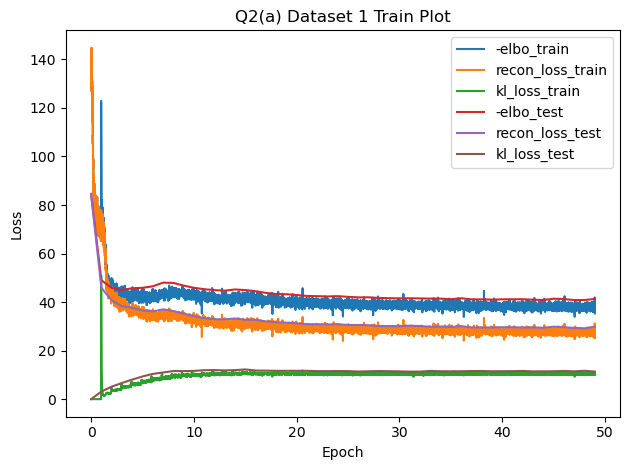

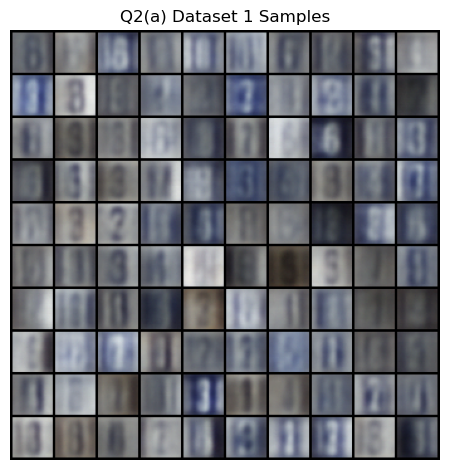

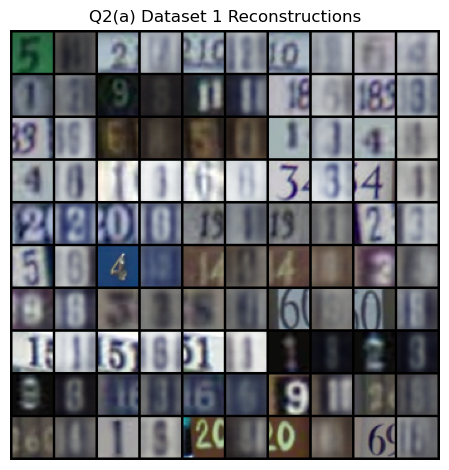

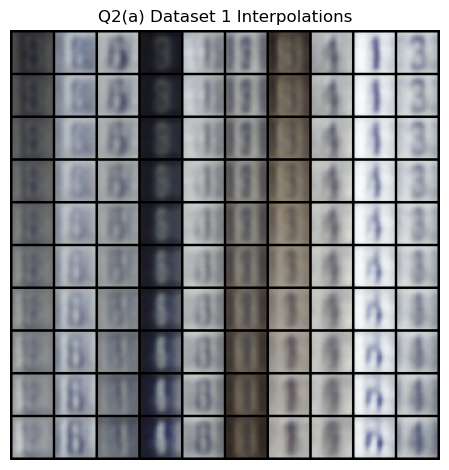

In [12]:
q2_save_results('a', 1, q2_a)

cuda:0


  2%|▏         | 1/50 [00:01<00:49,  1.01s/it]

141.09019470214844 141.09019470214844 0.0


  4%|▍         | 2/50 [00:01<00:47,  1.01it/s]

107.76764678955078 102.53643798828125 5.231207847595215


  6%|▌         | 3/50 [00:02<00:46,  1.02it/s]

93.92508697509766 86.91293334960938 7.012156009674072


  8%|▊         | 4/50 [00:03<00:45,  1.01it/s]

90.06809997558594 80.69701385498047 9.37108325958252


 10%|█         | 5/50 [00:04<00:44,  1.01it/s]

90.15767669677734 79.33049011230469 10.827184677124023


 12%|█▏        | 6/50 [00:05<00:43,  1.01it/s]

91.0750961303711 78.75579071044922 12.319306373596191


 14%|█▍        | 7/50 [00:06<00:42,  1.01it/s]

92.26443481445312 78.49024200439453 13.774189949035645


 16%|█▌        | 8/50 [00:07<00:41,  1.01it/s]

93.30990600585938 78.60872650146484 14.701180458068848


 18%|█▊        | 9/50 [00:08<00:40,  1.01it/s]

95.20867919921875 79.5645980834961 15.644079208374023


 20%|██        | 10/50 [00:09<00:40,  1.01s/it]

96.49950408935547 80.15411376953125 16.34539222717285


 22%|██▏       | 11/50 [00:10<00:39,  1.00s/it]

97.39845275878906 79.8689193725586 17.529531478881836


 24%|██▍       | 12/50 [00:11<00:38,  1.00s/it]

98.18314361572266 80.2642593383789 17.918886184692383


 26%|██▌       | 13/50 [00:12<00:36,  1.00it/s]

99.54081726074219 80.77876281738281 18.762056350708008


 28%|██▊       | 14/50 [00:13<00:36,  1.01s/it]

100.08216857910156 80.66617584228516 19.415990829467773


 30%|███       | 15/50 [00:14<00:35,  1.00s/it]

101.08738708496094 81.46466827392578 19.62272071838379


 32%|███▏      | 16/50 [00:15<00:33,  1.00it/s]

101.29653930664062 81.3918228149414 19.904712677001953


 34%|███▍      | 17/50 [00:16<00:32,  1.01it/s]

99.87764739990234 80.00140380859375 19.876243591308594


 36%|███▌      | 18/50 [00:17<00:31,  1.01it/s]

98.36329650878906 78.77105712890625 19.592243194580078


 38%|███▊      | 19/50 [00:18<00:30,  1.01it/s]

96.59632873535156 77.43222045898438 19.164108276367188


 40%|████      | 20/50 [00:19<00:29,  1.02it/s]

95.09293365478516 76.21220397949219 18.88072967529297


 42%|████▏     | 21/50 [00:20<00:28,  1.02it/s]

93.64604187011719 74.8236083984375 18.822429656982422


 44%|████▍     | 22/50 [00:21<00:27,  1.02it/s]

92.25022888183594 73.53218078613281 18.71804428100586


 46%|████▌     | 23/50 [00:22<00:26,  1.02it/s]

90.91065979003906 72.2464370727539 18.664222717285156


 48%|████▊     | 24/50 [00:23<00:25,  1.02it/s]

88.46517944335938 69.19088745117188 19.274290084838867


 50%|█████     | 25/50 [00:24<00:24,  1.02it/s]

87.44976806640625 68.15352630615234 19.296245574951172


 52%|█████▏    | 26/50 [00:25<00:23,  1.02it/s]

86.48574829101562 67.28688049316406 19.19886589050293


 54%|█████▍    | 27/50 [00:26<00:22,  1.02it/s]

86.04446411132812 66.78729248046875 19.257173538208008


 56%|█████▌    | 28/50 [00:27<00:21,  1.02it/s]

85.49886322021484 65.99626922607422 19.502592086791992


 58%|█████▊    | 29/50 [00:28<00:20,  1.02it/s]

84.94963073730469 65.67924499511719 19.270387649536133


 60%|██████    | 30/50 [00:29<00:19,  1.02it/s]

84.7685546875 65.3563003540039 19.412250518798828


 62%|██████▏   | 31/50 [00:30<00:18,  1.02it/s]

84.53453063964844 65.11753845214844 19.416994094848633


 64%|██████▍   | 32/50 [00:31<00:17,  1.02it/s]

84.43453979492188 64.84711456298828 19.58742904663086


 66%|██████▌   | 33/50 [00:32<00:16,  1.02it/s]

83.81803894042969 64.19608306884766 19.621952056884766


 68%|██████▊   | 34/50 [00:33<00:15,  1.02it/s]

83.65447235107422 64.02224731445312 19.632225036621094


 70%|███████   | 35/50 [00:34<00:14,  1.02it/s]

83.26054382324219 63.64314270019531 19.61739730834961


 72%|███████▏  | 36/50 [00:35<00:13,  1.02it/s]

83.01185607910156 63.09779739379883 19.9140567779541


 74%|███████▍  | 37/50 [00:36<00:12,  1.02it/s]

82.93798065185547 63.09451675415039 19.84346580505371


 76%|███████▌  | 38/50 [00:37<00:11,  1.02it/s]

82.53594970703125 62.92818069458008 19.607769012451172


 78%|███████▊  | 39/50 [00:38<00:10,  1.02it/s]

82.46761322021484 62.882354736328125 19.58525848388672


 80%|████████  | 40/50 [00:39<00:09,  1.02it/s]

82.2761001586914 62.35734939575195 19.91874885559082


 82%|████████▏ | 41/50 [00:40<00:08,  1.02it/s]

82.92259216308594 63.27744674682617 19.64514923095703


 84%|████████▍ | 42/50 [00:41<00:07,  1.02it/s]

81.96670532226562 62.1141471862793 19.85256004333496


 86%|████████▌ | 43/50 [00:42<00:06,  1.02it/s]

81.7780990600586 61.811790466308594 19.966310501098633


 88%|████████▊ | 44/50 [00:43<00:05,  1.02it/s]

81.888671875 61.84771728515625 20.040958404541016


 90%|█████████ | 45/50 [00:44<00:04,  1.02it/s]

81.7213134765625 61.50200653076172 20.219308853149414


 92%|█████████▏| 46/50 [00:45<00:03,  1.02it/s]

81.42988586425781 61.458377838134766 19.971511840820312


 94%|█████████▍| 47/50 [00:46<00:02,  1.02it/s]

81.35813903808594 61.01515579223633 20.34298324584961


 96%|█████████▌| 48/50 [00:47<00:01,  1.02it/s]

81.30513000488281 61.02573776245117 20.279388427734375


 98%|█████████▊| 49/50 [00:48<00:00,  1.02it/s]

81.26646423339844 61.18174362182617 20.0847225189209


100%|██████████| 50/50 [00:49<00:00,  1.01it/s]

80.9468994140625 60.73746109008789 20.209434509277344
(100, 32, 32, 3) 253 9
(100, 32, 32, 3) 255 0
Final -ELBO: 80.9469, Recon Loss: 60.7375, KL Loss: 20.2094


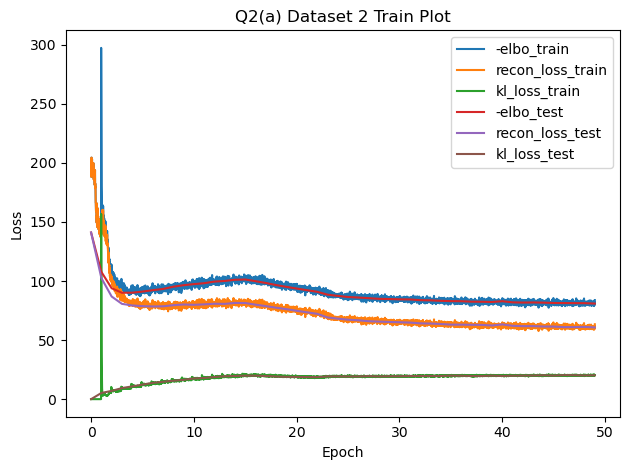

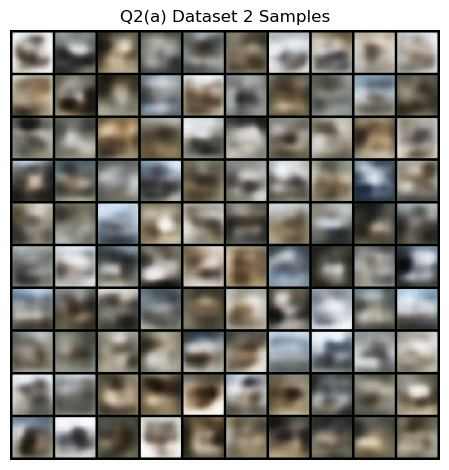

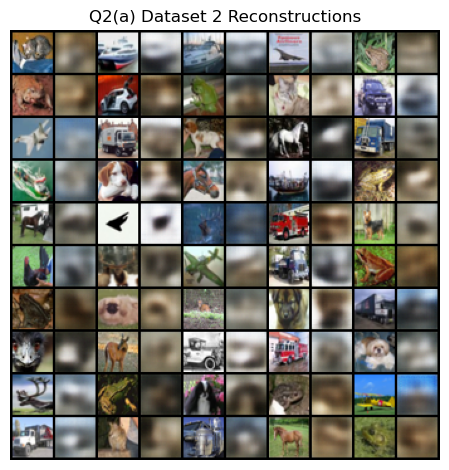

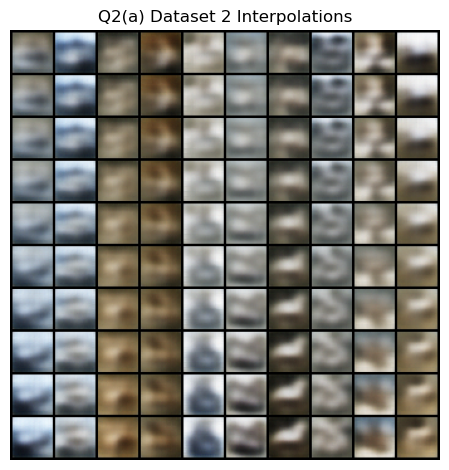

In [13]:
q2_save_results('a', 2, q2_a)

## Part (b) Hierarchical VAE [20pts]

In this part, we will explore a simplified version of the hierarchical VAE described in [NVAE](https://arxiv.org/pdf/2007.03898.pdf). We will not implement the full NVAE, but rather use some ideas from the paper to explore how to learn a prior distribution p(z).

Implement a hierarchical VAE that follows the following structure.
* $z1$ is a 2x2x12 latent vector where p(z1) is the unit Gaussian.
    * Learn the approximate posterior $q_\theta(z|x) = N(z; \mu_\theta(x), \Sigma_\theta(x))$, where $\mu_\theta(x)$ is the mean vector, and $\Sigma_\theta(x)$ is a diagonal covariance matrix. I.e., same as a normal VAE, but use a matrix latent rather than a vector. Each dimension is independent.
* $z2$ is a 2x2x12 latent vector.
    * $p_\theta(z2|z1)$ is learned, and implemented as a neural network that parameterizes mean (and log std, optionally).
    * $q_\theta(z2|z1,x)$ is also learned. Implement this as a Residual Normal [see NVAE] over the prior $p_\theta(z2|z1)$.
* The decoder should be a function of $z2$ only.

Some helpful hints:
* Two KL losses should be calculated. The first should match $q_\theta(z|x)$ to the unit Gaussian. The second should match $q_\theta(z2|z1,x)$ and $p_\theta(z2|z1)$, and be taken with respect to $q$.
* When calculating the second KL term, utilize the analytic form for the residual normal. When $q_\theta(z2|z1,x) = N(z2; \mu_\theta(z1) + \Delta \mu_\theta(z1,x), \Sigma_\theta(z1)) * \Delta \Sigma_\theta(z1,x))$, use the following form: `kl_z2 = -z2_residual_logstd - 0.5 + (torch.exp(2 * z2_residual_logstd) + z2_residual_mu ** 2) * 0.5`
* When calculating KL, remember to sum over the dimensions of the latent variable before taking the mean over batch.
* For the prior $p_\theta(z2|z1)$, fix standard deviation to be 1. Learn only the mean. This will help with stability in training.

The following network structures may be useful:
```
conv2d(in_channels, out_channels, kernel_size, stride, padding)
transpose_conv2d(in_channels, out_channels, kernel_size, stride, padding)
linear(in_dim, out_dim)

Encoder
        nn.Conv2d(3 + 12, 32, 3, padding=1), # [32, 32, 32]
        LayerNorm(32),
        nn.ReLU(),
        nn.Conv2d(32, 64, 3, stride=2, padding=1), # [64, 16, 16]
        LayerNorm(64),
        nn.ReLU(),
        nn.Conv2d(64, 64, 3, stride=2, padding=1), # [64, 8, 8]
        LayerNorm(64),
        nn.ReLU(),
        nn.Conv2d(64, 64, 3, stride=2, padding=1), # [64, 4, 4]
        LayerNorm(64),
        nn.ReLU(),
        nn.Conv2d(64, 64, 3, stride=2, padding=1), # [64, 2, 2]
        LayerNorm(64),
        nn.ReLU(),
        nn.Conv2d(64, 12*2, 3, padding=1), # [12*2, 2, 2]
We assume encoder networks are of the form p(z'|z,x).
When learning q(z1), an x of all zeros can be used as input.
Upscale z with nearest-neighbor projection before concatenating with x.


Decoder
        nn.ConvTranspose2d(12, 64, 3, padding=1), # [64, 2, 2]
        nn.ReLU(),
        nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1), # [64, 4, 4]
        nn.ReLU(),
        nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1), # [64, 8, 8]
        nn.ReLU(),
        nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1), # [64, 16, 16]
        nn.ReLU(),
        nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1), # [32, 32, 32]
        nn.ReLU(),
        nn.Conv2d(32, 3, 3, padding=1), # [3, 32, 32]
```


**You will provide the following deliverables**


1.   Over the course of training, record the average full negative ELBO, reconstruction loss, and KL term of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
2.   Report the final test set performance of your final model
3. 100 samples from your trained VAE
4. 50 real-image / reconstruction pairs (for some $x$, encode and then decode)
5. 10 interpolations of 10 images from your trained VAE (100 images total)




### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [8]:
def q2_b(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    test_data: An (n_test, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
    - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
    - a (100, 32, 32, 3) numpy array of 100 samples from your VAE with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
      FROM THE TEST SET with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 10 interpolations of length 10 between
      pairs of test images. The output should be those 100 images flattened into
      the specified shape with values in {0, ..., 255}
    """

    class ImageDataset(Dataset):
        def __init__(self, data: np.array):
            self.data = data.transpose((0, 3, 1, 2)).astype(np.float32) / 255.

        def __len__(self):
            return self.data.shape[0]

        def __getitem__(self, idx):
            return self.data[idx]


    class VAE(nn.Module):
        def __init__(self, latent_size: int):
            super(VAE, self).__init__()

            self.latent_size = 12  # channels
            self.z1_mu = nn.Parameter(torch.zeros((1, 12, 2, 2)))
            self.z1_logvar = nn.Parameter(torch.zeros((1, 12, 2, 2)))


            self.input_encoder = nn.Sequential(nn.Conv2d(3, 32, 3, padding=1), # [32, 32, 32]
                                        nn.BatchNorm2d(32),
                                        nn.ReLU(),
                                        nn.Conv2d(32, 64, 3, stride=2, padding=1), # [64, 16, 16]
                                        nn.BatchNorm2d(64),
                                        nn.ReLU(),
                                        nn.Conv2d(64, 64, 3, stride=2, padding=1),) # [64, 8, 8]
                                        # nn.InstanceNorm2d(64),
                                        # nn.ReLU(),
                                        # nn.Conv2d(64, 64, 3, stride=2, padding=1), # [64, 4, 4]
                                        # nn.InstanceNorm2d(64),
                                        # nn.ReLU(),
                                        # nn.Conv2d(64, 64, 3, stride=2, padding=1), # [64, 2, 2]
                                        # nn.InstanceNorm2d(64),
                                        # nn.ReLU(),
                                        # nn.Conv2d(64, 12*2, 3, padding=1)) # [12*2, 2, 2])

            self.encoder = nn.Sequential(
                                        nn.Conv2d(64, 64, 3, stride=2, padding=1), # [64, 4, 4]
                                        nn.BatchNorm2d(64),
                                        nn.ReLU(),
                                        nn.Conv2d(64, 64, 3, stride=2, padding=1), # [64, 2, 2]
                                        nn.BatchNorm2d(64),
                                        nn.ReLU(),
                                        nn.Conv2d(64, 12*2, 3, padding=1)) # [12*2, 2, 2])

            self.upscale = nn.Sequential(nn.Conv2d(64, 128, 3, stride=1, padding=1))

            self.decoder1 = nn.Sequential(nn.ConvTranspose2d(12, 64, 3, padding=1), # [64, 2, 2]
                                          # nn.LayerNorm([64, 2, 2]),
                                        nn.ReLU(),
                                        nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1), # [64, 4, 4]
                                          # nn.LayerNorm([64, 4, 4]),
                                        nn.ReLU(),
                                        nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1),) # [64, 8, 8]
                                        # nn.ReLU(),
                                        # nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1), # [64, 16, 16]
                                        # nn.ReLU(),
                                        # nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1), # [32, 32, 32]
                                        # nn.ReLU(),
                                        # nn.Conv2d(32, 3, 3, padding=1)) # [3, 32, 32])


            self.decoder2 = nn.Sequential(nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1), # [64, 16, 16]
                                          # nn.LayerNorm([64, 16, 16]),
                                            nn.ReLU(),
                                            nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1), # [64, 32, 32]
                                          # nn.LayerNorm([64, 32, 32]),
                                            nn.ReLU(),
                                            nn.Conv2d(64, 3, 3, padding=1)) # [3, 32, 32])

        def encode(self, x):
            h2 = self.input_encoder(x)
            enc = self.upscale(h2)
            z2_dmu, z2_dlogvar  = enc[:, :64], enc[:, 64:]
            # z2 = self._sample_gaussian(z2_mu, z2_logvar, x.device)

            h1 = self.encoder(h2)
            z1_dmu, z1_dlogvar  = h1[:, :12], h1[:, 12:]
            # z1 = self._sample_gaussian(z1_mu, z1_logvar, x.device)
            # print("z1", z1.shape)

            return z1_dmu, z1_dlogvar, z2_dmu, z2_dlogvar

        def sample(self, num: int, device):
            z1 = self._sample_gaussian(self.z1_mu.expand(num, -1, -1, -1), self.z1_logvar.expand(num, -1, -1, -1), device)
            # print("z1", z1.shape)

            h2 = self.decoder1(z1 + self.z1_mu)
            dec2 = self.upscale(h2)
            z2_mu, z2_logvar = dec2[:, :64], dec2[:, 64:]
            z2 = self._sample_gaussian(z2_mu, z2_logvar, device)
            # print("z2", z2.shape)

            out = F.sigmoid(self.decoder2(z2 + h2))
            return out

        def _sample_gaussian(self, mu, std, device):
            eps = torch.randn_like(std, device=device)
            return mu + eps * std

        def forward(self, x: torch.Tensor) -> torch.Tensor:
            z1_delta_mu, z1_delta_logvar, z2_delta_mu, z2_delta_logvar = self.encode(x)
            z1_std = torch.exp(0.5 * self.z1_logvar)
            z1_delta_std = torch.exp(0.5 * z1_delta_logvar)

            z1 = self._sample_gaussian(self.z1_mu + z1_delta_mu, z1_std * z1_delta_std, device)
            # print("z1", z1.shape)

            h2 = self.decoder1(z1 + self.z1_mu) # TODO: fix upscale
            dec2 = self.upscale(h2)
            z2_mu, z2_logvar = dec2[:, :64], dec2[:, 64:]
            z2_std = torch.exp(0.5 * z2_logvar)
            z2_delta_std = torch.exp(0.5 * z2_delta_logvar)
            z2 = self._sample_gaussian(z2_mu + z2_delta_mu, z2_std * z2_delta_std, device)
            # print("z2", z2.shape, h2.shape)

            out = F.sigmoid(self.decoder2(z2 + h2))
            return out, z1_delta_mu, z1_delta_logvar, z2_delta_mu, z2_delta_logvar, self.z1_logvar, z2_logvar

    def sample_new(model, num: int, device) -> np.array:
        out = model.sample(num, device).detach().cpu().numpy() * 255
        return out.astype(np.uint8).transpose(0, 2, 3, 1)

    def sample_reconstruction(model, x: torch.tensor) -> np.array:
        out, _, _, _, _, _, _ = model(x)
        h = torch.cat([x, out], dim=0).detach().cpu().numpy() * 255
        indices = torch.arange(2 * x.shape[0]).view(2, -1).T.flatten()
        return h[indices].astype(np.uint8).transpose(0, 2, 3, 1)


    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # device = "cpu"
    print(device)

    train_dataset = ImageDataset(train_data)
    train_dataloader = DataLoader(train_dataset, batch_size=512, shuffle=True)

    test_dataset = ImageDataset(test_data)
    test_dataloader = DataLoader(test_dataset, batch_size=512, shuffle=False)

    epoch = 35
    model = VAE(12).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    cosine_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epoch, eta_min=1e-4)

    BETA_1 = 1.
    BETA_2 = 1.

    train_losses = []
    test_losses = []
    for e in tqdm(range(epoch)):
        BETA_1 = min(1.0, e / 15)
        BETA_2 = min(1.0, e / 15)
        model.train()
        for X in train_dataloader:
            X = X.to(device)
            logits, z1_delta_mu, z1_delta_logvar, z2_delta_mu, z2_delta_logvar, z1_logvar, z2_logvar = model(X)
            # print(logits.shape, X.shape)

            optimizer.zero_grad()

            mse = F.mse_loss(logits, X, reduction='sum') / X.shape[0]
            z1_var = torch.exp(z1_logvar)
            z2_var = torch.exp(z2_logvar)
            kl_z1 = 0.5 * BETA_1 * torch.sum(-1 - z1_delta_logvar + (z1_delta_mu ** 2 / z1_var) + torch.exp(z1_delta_logvar)) / X.shape[0]
            kl_z2 = 0.5 * BETA_2 * torch.sum(-1 - z2_delta_logvar + (z2_delta_mu ** 2 / z2_var) + torch.exp(z2_delta_logvar)) / X.shape[0]
            # print(mse, kl_z1, kl_z2)

            loss = mse + kl_z1 + kl_z2

            train_losses.append(np.array([loss.item(), mse.item(), kl_z1.item()]))

            loss.backward()
            # utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()


        cosine_scheduler.step()
        mse = 0
        kl1 = 0
        kl2 = 0
        model.eval()
        with torch.no_grad():
            for Y in test_dataloader:
                Y = Y.to(device)
                logits, z1_delta_mu, z1_delta_logvar, z2_delta_mu, z2_delta_logvar, z1_logvar, z2_logvar = model(Y)
                mse += F.mse_loss(logits, Y, reduction='sum')
                z1_var = torch.exp(z1_logvar)
                z2_var = torch.exp(z2_logvar)
                kl1 += 0.5 * BETA_1 * torch.sum(-1 - z1_delta_logvar + (z1_delta_mu ** 2 / z1_var) + torch.exp(z1_delta_logvar))
                kl2 += 0.5 * BETA_2 * torch.sum(-1 - z2_delta_logvar + (z2_delta_mu ** 2 / z2_var) + torch.exp(z2_delta_logvar))

            mse /= len(test_dataset)
            kl1 /= len(test_dataset)
            kl2 /= len(test_dataset)
            ll = mse + kl1 + kl2
            tqdm.write(f"{ll.detach().cpu().item():.2f} {mse.detach().cpu().item():.2f} {kl1.detach().cpu().item():.2f} {kl2.detach().cpu().item():.2f}")
            test_losses.append(np.array([ll.detach().cpu(), mse.detach().cpu(),  (kl1 + kl2).detach().cpu()]))


    model.eval()
    samples = sample_new(model, 100, device)
    # print(samples.shape, samples.max(), samples.min())
    reconstruction = sample_reconstruction(model, torch.tensor(test_dataset[:50]).to(device))
    # print(reconstruction.shape, reconstruction.max(), reconstruction.min())
    # interpolation = sample_interpolation(model, torch.tensor(test_dataset[:20]).to(device))

    return np.stack(train_losses), np.stack(test_losses), samples, reconstruction, reconstruction


### Results
Once you've finished `q2_b`, execute the cells below to visualize and save your results.

cuda:0


  3%|▎         | 1/35 [00:01<01:01,  1.82s/it]

5.72 5.72 0.00 0.00


  6%|▌         | 2/35 [00:03<00:59,  1.80s/it]

30.04 18.62 0.57 10.86


  9%|▊         | 3/35 [00:05<00:57,  1.81s/it]

34.69 23.04 1.55 10.10


 11%|█▏        | 4/35 [00:07<00:56,  1.81s/it]

35.86 24.78 2.56 8.52


 14%|█▍        | 5/35 [00:09<00:54,  1.81s/it]

35.38 25.48 3.72 6.18


 17%|█▋        | 6/35 [00:10<00:53,  1.84s/it]

35.63 25.64 4.90 5.10


 20%|██        | 7/35 [00:12<00:51,  1.85s/it]

35.80 26.02 5.82 3.97


 23%|██▎       | 8/35 [00:14<00:49,  1.84s/it]

36.04 26.29 6.55 3.20


 26%|██▌       | 9/35 [00:16<00:47,  1.83s/it]

36.66 26.88 7.36 2.42


 29%|██▊       | 10/35 [00:18<00:45,  1.82s/it]

36.43 26.75 7.94 1.74


 31%|███▏      | 11/35 [00:20<00:43,  1.82s/it]

36.86 26.90 8.55 1.41


 34%|███▍      | 12/35 [00:21<00:41,  1.82s/it]

37.64 27.71 9.01 0.92


 37%|███▋      | 13/35 [00:23<00:40,  1.82s/it]

38.74 27.92 9.85 0.96


 40%|████      | 14/35 [00:25<00:38,  1.82s/it]

37.99 26.97 10.42 0.60


 43%|████▎     | 15/35 [00:27<00:36,  1.82s/it]

38.74 27.54 10.74 0.45


 46%|████▌     | 16/35 [00:29<00:34,  1.82s/it]

39.26 27.83 11.07 0.36


 49%|████▊     | 17/35 [00:30<00:32,  1.81s/it]

39.09 27.51 11.19 0.39


 51%|█████▏    | 18/35 [00:32<00:30,  1.81s/it]

39.17 28.10 10.75 0.32


 54%|█████▍    | 19/35 [00:34<00:28,  1.81s/it]

39.19 27.69 11.18 0.32


 57%|█████▋    | 20/35 [00:36<00:27,  1.81s/it]

38.87 27.44 11.16 0.27


 60%|██████    | 21/35 [00:38<00:25,  1.81s/it]

38.33 26.86 11.24 0.23


 63%|██████▎   | 22/35 [00:40<00:23,  1.81s/it]

38.94 27.71 11.02 0.21


 66%|██████▌   | 23/35 [00:41<00:21,  1.82s/it]

38.54 26.94 11.39 0.21


 69%|██████▊   | 24/35 [00:43<00:19,  1.81s/it]

38.52 27.27 11.05 0.20


 71%|███████▏  | 25/35 [00:45<00:18,  1.82s/it]

37.95 26.61 11.18 0.17


 74%|███████▍  | 26/35 [00:47<00:16,  1.82s/it]

37.94 26.36 11.40 0.19


 77%|███████▋  | 27/35 [00:49<00:14,  1.82s/it]

37.89 26.39 11.33 0.17


 80%|████████  | 28/35 [00:50<00:12,  1.81s/it]

38.00 26.41 11.42 0.17


 83%|████████▎ | 29/35 [00:52<00:10,  1.81s/it]

37.95 26.55 11.21 0.19


 86%|████████▌ | 30/35 [00:54<00:09,  1.82s/it]

38.14 26.45 11.48 0.21


 89%|████████▊ | 31/35 [00:56<00:07,  1.82s/it]

37.77 26.31 11.34 0.11


 91%|█████████▏| 32/35 [00:58<00:05,  1.81s/it]

37.78 26.30 11.35 0.13


 94%|█████████▍| 33/35 [00:59<00:03,  1.81s/it]

37.65 26.11 11.40 0.13


 97%|█████████▋| 34/35 [01:01<00:01,  1.81s/it]

37.69 26.04 11.53 0.12


100%|██████████| 35/35 [01:03<00:00,  1.83s/it]

37.64 26.09 11.41 0.14
Final -ELBO: 37.6359, Recon Loss: 26.0862, KL Loss: 11.5496


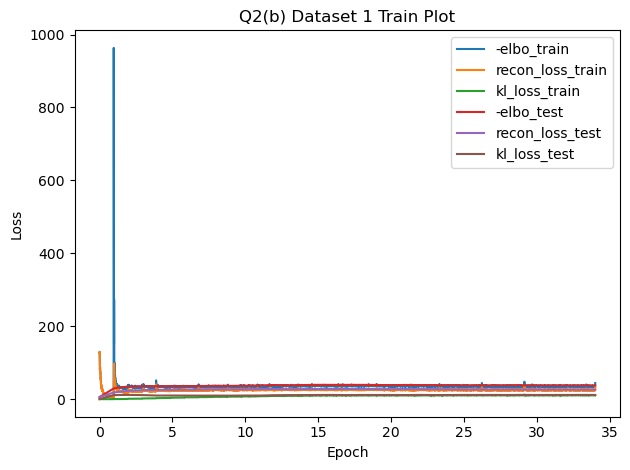

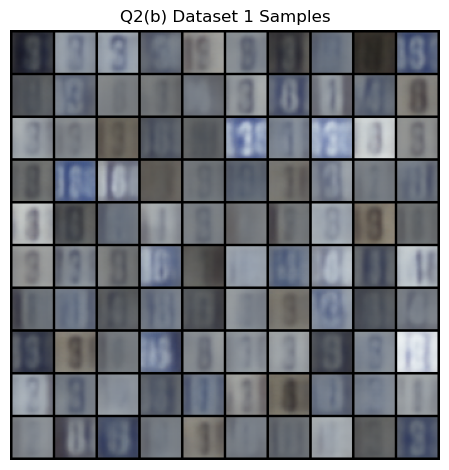

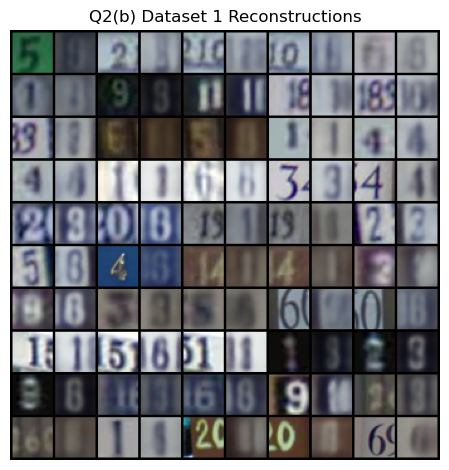

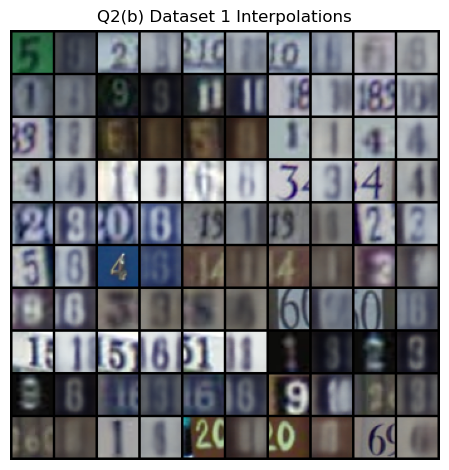

In [63]:
q2_save_results('b', 1, q2_b)

In [12]:
!cp cifar10.pkl deepul/homeworks/hw2/data/cifar10.pkl

cuda:0


  3%|▎         | 1/35 [00:01<00:53,  1.57s/it]

24.63 24.63 0.00 0.00


  6%|▌         | 2/35 [00:02<00:44,  1.34s/it]

54.29 38.23 0.01 16.05


  9%|▊         | 3/35 [00:03<00:40,  1.27s/it]

63.73 42.52 0.06 21.15


 11%|█▏        | 4/35 [00:05<00:38,  1.23s/it]

62.63 41.04 0.61 20.98


 14%|█▍        | 5/35 [00:06<00:36,  1.21s/it]

63.01 39.92 1.02 22.07


 17%|█▋        | 6/35 [00:07<00:34,  1.21s/it]

66.30 41.97 1.76 22.57


 20%|██        | 7/35 [00:08<00:33,  1.20s/it]

69.31 43.80 2.17 23.34


 23%|██▎       | 8/35 [00:09<00:32,  1.20s/it]

72.45 43.94 2.81 25.69


 26%|██▌       | 9/35 [00:11<00:30,  1.19s/it]

74.59 47.96 3.20 23.42


 29%|██▊       | 10/35 [00:12<00:29,  1.19s/it]

77.07 49.94 3.46 23.67


 31%|███▏      | 11/35 [00:13<00:28,  1.19s/it]

79.31 50.35 3.90 25.07


 34%|███▍      | 12/35 [00:14<00:27,  1.19s/it]

82.44 52.56 4.37 25.51


 37%|███▋      | 13/35 [00:15<00:26,  1.19s/it]

83.93 55.93 4.94 23.06


 40%|████      | 14/35 [00:16<00:24,  1.19s/it]

85.38 56.18 5.74 23.46


 43%|████▎     | 15/35 [00:18<00:23,  1.19s/it]

86.89 57.61 7.06 22.22


 46%|████▌     | 16/35 [00:19<00:22,  1.19s/it]

88.18 60.85 8.57 18.76


 49%|████▊     | 17/35 [00:20<00:21,  1.19s/it]

86.60 60.36 9.55 16.69


 51%|█████▏    | 18/35 [00:21<00:20,  1.19s/it]

86.13 61.41 10.69 14.03


 54%|█████▍    | 19/35 [00:22<00:18,  1.19s/it]

85.01 61.61 10.67 12.73


 57%|█████▋    | 20/35 [00:24<00:17,  1.19s/it]

84.29 60.62 11.46 12.21


 60%|██████    | 21/35 [00:25<00:16,  1.19s/it]

83.87 60.47 12.08 11.33


 63%|██████▎   | 22/35 [00:26<00:15,  1.18s/it]

83.50 60.22 12.31 10.98


 66%|██████▌   | 23/35 [00:27<00:14,  1.19s/it]

83.15 60.38 12.27 10.51


 69%|██████▊   | 24/35 [00:28<00:13,  1.19s/it]

82.89 60.28 12.35 10.25


 71%|███████▏  | 25/35 [00:30<00:11,  1.19s/it]

82.44 59.63 12.94 9.87


 74%|███████▍  | 26/35 [00:31<00:10,  1.18s/it]

82.63 60.15 13.00 9.48


 77%|███████▋  | 27/35 [00:32<00:09,  1.18s/it]

82.14 59.87 12.97 9.29


 80%|████████  | 28/35 [00:33<00:08,  1.18s/it]

82.10 59.83 13.35 8.91


 83%|████████▎ | 29/35 [00:34<00:07,  1.18s/it]

81.75 59.80 13.28 8.68


 86%|████████▌ | 30/35 [00:35<00:05,  1.18s/it]

81.64 59.59 13.42 8.62


 89%|████████▊ | 31/35 [00:37<00:04,  1.18s/it]

81.67 60.22 13.63 7.83


 91%|█████████▏| 32/35 [00:38<00:03,  1.18s/it]

81.34 59.60 13.74 7.99


 94%|█████████▍| 33/35 [00:39<00:02,  1.18s/it]

81.35 59.67 13.72 7.96


 97%|█████████▋| 34/35 [00:40<00:01,  1.18s/it]

81.25 59.64 13.86 7.76


100%|██████████| 35/35 [00:41<00:00,  1.20s/it]

81.30 59.93 13.82 7.55
Final -ELBO: 81.2956, Recon Loss: 59.9283, KL Loss: 21.3673


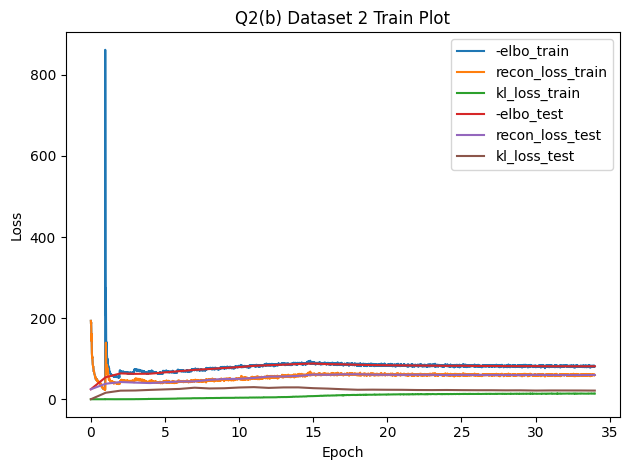

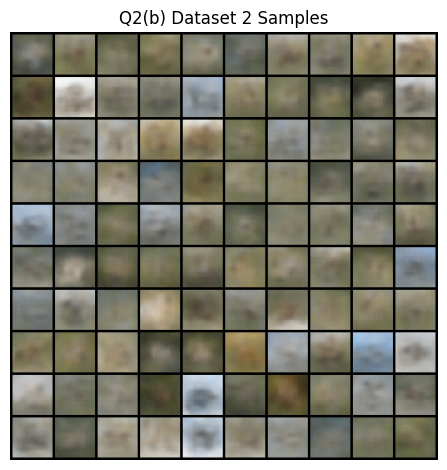

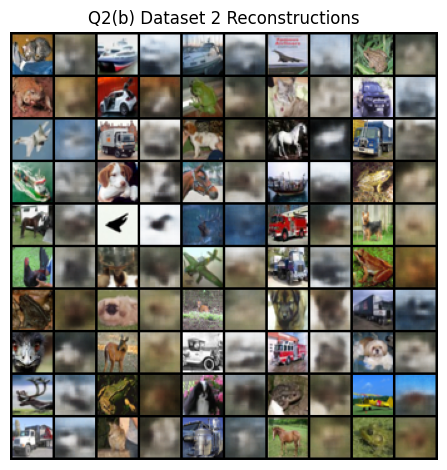

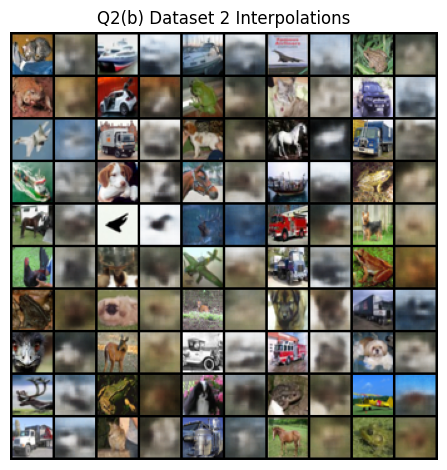

In [13]:
q2_save_results('b', 2, q2_b)

# Question 3: VQ-VAE [40pts]
In this question, you with train a [VQ-VAE](https://arxiv.org/abs/1711.00937) on the colored shapes dataset and SVHN. If you are confused on how the VQ-VAE works, you may find [Lilian Weng's blogpost](https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html#vq-vae-and-vq-vae-2) to be useful.

You may experiment with different hyperparameters and architecture designs, but the following designs for the VQ-VAE architecture may be useful.

```
conv2d(in_channels, out_channels, kernel_size, stride, padding)
transpose_conv2d(in_channels, out_channels, kernel_size, stride, padding)
linear(in_dim, out_dim)
batch_norm2d(dim)

residual_block(dim)
    batch_norm2d(dim)
    relu()
    conv2d(dim, dim, 3, 1, 1)
    batch_norm2d(dim)
    relu()
    conv2d(dim, dim, 1, 1, 0)

Encoder
    conv2d(3, 256, 4, 2, 1) 16 x 16
    batch_norm2d(256)
    relu()
    conv2d(256, 256, 4, 2, 1) 8 x 8
    residual_block(256)
    residual_block(256)

Decoder
    residual_block(256)
    residual_block(256)
    batch_norm2d(256)
    relu()
    transpose_conv2d(256, 256, 4, 2, 1) 16 x 16
    batch_norm2d(256)
    relu()
    transpose_conv2d(256, 3, 4, 2, 1) 32 x 32
```

A few other tips:
*   Use a codebook with $K = 128$ latents each with a $D = 256$ dimensional embedding vector
*   You should initialize each element in your $K\times D$ codebook to be uniformly random in $[-1/K, 1/K]$
*   Use batch size 128 with a learning rate of $10^{-3}$ and an Adam optimizer
*   Center and scale your images to $[-1, 1]$
*   Supposing that $z_e(x)$ is the encoder output, and $z_q(x)$ is the quantized output using the codebook, you can implement the straight-through estimator as follows (where below is fed into the decoder):
  * `(z_q(x) - z_e(x)).detach() + z_e(x)` in Pytorch
  * `tf.stop_gradient(z_q(x) - z_e(x)) + z_e(x)` in Tensorflow.

In addition to training the VQ-VAE, you will also need to train a Transformer prior on the categorical latents in order to sample. Feel free to use your implementation for HW1! You should flatten the VQ-VAE tokens into a [H x W] sequence, and use a start token.

**You will provide the following deliverables**


1.   Over the course of training, record the average loss of the training data (per minibatch) and test data (for your entire test set) **for both your VQ-VAE and Transformer prior**. Code is provided that automatically plots the training curves.
2. Report the final test set performances of your final models
3. 100 samples from your trained VQ-VAE and Transformer prior
4. 50 real-image / reconstruction pairs (for some $x$, encode and then decode)

## Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [ ]:
def q3(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 32, 32, 3) uint8 numpy array of color images with values in [0, 255]
    test_data: An (n_test, 32, 32, 3) uint8 numpy array of color images with values in [0, 255]
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of VQ-VAE train losess evaluated every minibatch
    - a (# of epochs + 1,) numpy array of VQ-VAE test losses evaluated once at initialization and after each epoch
    - a (# of training iterations,) numpy array of Transformer prior train losess evaluated every minibatch
    - a (# of epochs + 1,) numpy array of Transformer prior test losses evaluated once at initialization and after each epoch
    - a (100, 32, 32, 3) numpy array of 100 samples with values in {0, ... 255}
    - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
      FROM THE TEST SET with values in [0, 255]
    """

    """ YOUR CODE HERE """

## Results
Once you've finished `q3`, execute the cells below to visualize and save your results.

In [ ]:
q3_save_results(1, q3)

In [ ]:
q3_save_results(2, q3)

# File Saving Utility


In [ ]:
# one way to save files
from google.colab import files
import os
import os.path as osp
for fname in os.listdir('results'):
    files.download('results/' + fname)